# Overexposure Extension and Blur
This notebook implements the overexposure extension and blur algorithm.
First it defines the necessary functions to load the image, extend the values above a certain limit, and apply the sum of Gaussians blur.
Then it defines the main function `bloom_image` that combines these steps.
Then it displays the 1D and 2D kernels used for the blur.
Then it applies the bloom image function to a sample image and displays the result.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
from utils.raw_utils import demosaic_bilinear
from utils.raw_utils import unpack_raw
#!pip install rawpy
import rawpy
from utils.raw_utils import pack_raw
from utils.dataset_navigation import get_image_paths
# from ipywidgets import interact, FloatSlider
from utils.post_processor import PostProcessor, get_gray_world_constants

In [212]:

def load_image(file_path, normalize=True):
    raw = rawpy.imread(file_path).raw_image_visible
    white_point = np.array(rawpy.imread(file_path).camera_white_level_per_channel)
    black_point = np.array(rawpy.imread(file_path).black_level_per_channel)
    raw = pack_raw(raw)
    if normalize:
        raw = (raw - black_point) / (white_point - black_point)
    else:
        raw = raw.astype(np.float32)
    return raw


def kernel_blur(img, kernel):
    return cv2.filter2D(img, -1, kernel)


def sum_of_gaussians_kernel(sigma1, sigma2, ratio, downscale_factor=1.0):

    
    # I found the original values working on a scale of 
    sigma1 = sigma1 / downscale_factor
    sigma2 = sigma2 / downscale_factor
    ratio = ratio * (downscale_factor ** 2)

    kernel_size = int(np.ceil(6 * max(sigma1, sigma2))) + 1
    
    radius = kernel_size // 2
    x = np.arange(-radius, radius + 1)
    xx, yy = np.meshgrid(x, x, indexing='ij')

    g1 = np.exp(-(xx**2 + yy**2) / (2 * sigma1**2))
    g2 = np.exp(-(xx**2 + yy**2) / (2 * sigma2**2))
    g_sum = g1 + ratio * g2
    g_sum /= np.sum(g_sum)  # normalize to sum to 1

    # Create 1D kernel for visualization
    d1_kernel = g_sum[radius+1, :]  # take the middle row as 1D kernel
    return g_sum.astype(np.float32), d1_kernel.astype(np.float32)

def sum_of_gaussians_seperable_blur(image, sigma1=0.5, sigma2=40, ratio=0.000004375, downscale_factor=1.0):
    """
    Apply a separable sum of Gaussians blur to an image.
    """

    # k_size = int(np.ceil(10 * sigma1))
    # radius = k_size // 2
    # # then build the x-axis for each:
    # x = np.arange(-radius, radius + 1)   # e.g. [-3σ₁,…,0,…,+3σ₁]
    # 
    # Adjust sigmas and ratio for downscaling
    sigma1 = sigma1 / downscale_factor
    sigma2 = sigma2 / downscale_factor
    ratio = ratio * (downscale_factor ** 2)  # adjust ratio for downscaling

    radius = int(np.ceil(10*max(sigma1, sigma2)))
    x = np.arange(-radius, radius+1)

    g1_1d = np.exp(-x**2/(2*sigma1**2))
    g2_1d = np.exp(-x**2/(2*sigma2**2))
    
    # Sums are squared for normalization because we need to capture the 2d weighting
    S1 = g1_1d.sum()**2
    S2 = g2_1d.sum()**2
    C  = S1 + ratio * S2

    b1 = cv2.sepFilter2D(image, -1, g1_1d, g1_1d)
    b2 = cv2.sepFilter2D(image, -1, g2_1d, g2_1d)

    out = (b1 + ratio * b2) / C
    return np.clip(out, 0, 1)


def extend(image, limit=1, factor=10, wb_constants=None):
    """
    Extend values above a certain limit by a factor.
    """
    extended_image = image.copy()
    # Build a mask for pixels where any channel exceeds the limit
    pixel_mask = (extended_image >= limit).any(axis=-1)  # shape (H, W)
    # Expand mask to all channels and apply
    # Put all pixels to the max value of the image
    # extended_image[pixel_mask] = np.max(extended_image, axis=-1, keepdims=True)[pixel_mask]
    # Make all the values of the mask follor the ratio of the wb_constants
    if wb_constants is not None:
        # Normalize the extended image by the white balance constants
        img_max = np.max(extended_image)
        wb_fixed_max = img_max / wb_constants
        extended_image[pixel_mask] = extended_image[pixel_mask] + (factor * wb_fixed_max)
        
    else:
        extended_image[pixel_mask] *= factor

    return extended_image


# def bloom_image(image, sigma1=0.5, sigma2=40, ratio=0.000004375, extend_factor=20, downscale_factor=1.0, method1=True):
def bloom_image(image, sigma1=0.5, sigma2=40, ratio=0.000004, extend_factor=20, downscale_factor=1.0, method1=True, wb_constants=None):

    extended = extend(image, limit=1, factor=extend_factor, wb_constants=wb_constants)
    if method1:
        kernel, _ = sum_of_gaussians_kernel(sigma1=sigma1, sigma2=sigma2, ratio=ratio, downscale_factor=downscale_factor)
        blurred_image = kernel_blur(extended, kernel)
    else:
        blurred_image = sum_of_gaussians_seperable_blur(extended, sigma1=sigma1, sigma2=sigma2, ratio=ratio, downscale_factor=downscale_factor)
    clipped_image = np.clip(blurred_image, 0, 1)
    return clipped_image




(241,)
241
120
-120 120
(241,)


/tmp/ipykernel_544478/3597485428.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


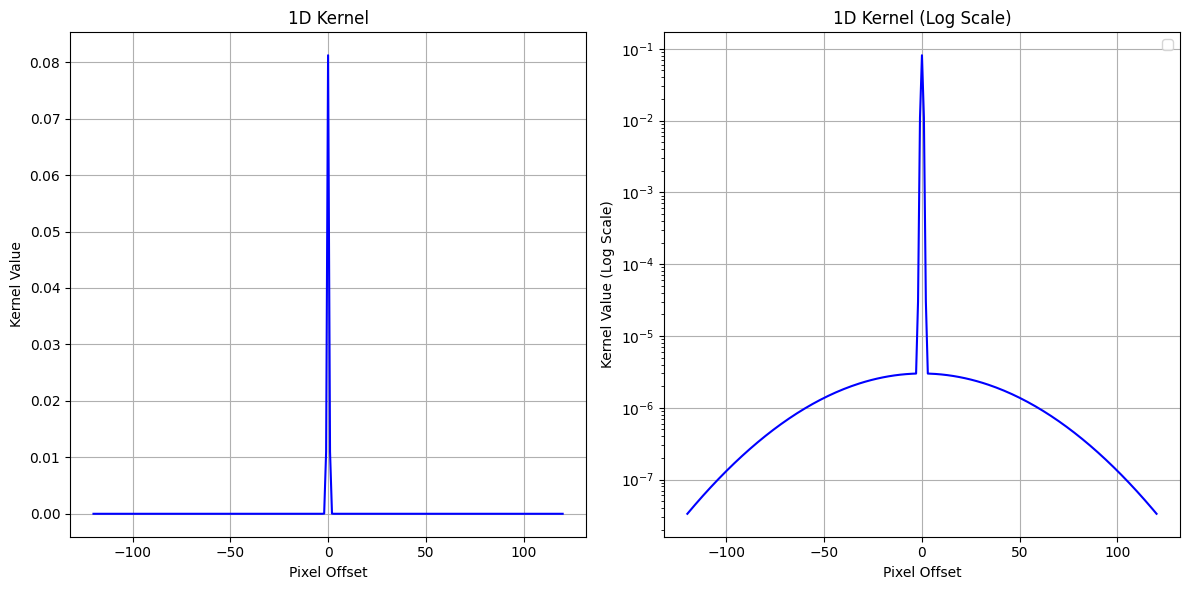

In [200]:
# Get the 1D kernel 
sigma1 = 0.5
sigma2 = 40
ratio = 0.000005
kernel, d1_kernel = sum_of_gaussians_kernel(sigma1=sigma1, sigma2=sigma2, ratio=ratio, downscale_factor=1)
print(d1_kernel.shape)
kernel_size = int(np.ceil(6 * max(sigma1, sigma2))) + 1
print(kernel_size)
print(kernel_size // 2)
r = kernel_size // 2
x = np.arange(-r, r + 1)
print(x[0], x[-1])
print(x.shape)
# Plot on two plots, one linear and one log scale
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, d1_kernel, label='1D Kernel', color='blue')
plt.title('1D Kernel')
plt.xlabel('Pixel Offset')
plt.ylabel('Kernel Value')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(x, d1_kernel, color='blue')
plt.title('1D Kernel (Log Scale)')
plt.xlabel('Pixel Offset')
plt.ylabel('Kernel Value (Log Scale)')
plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


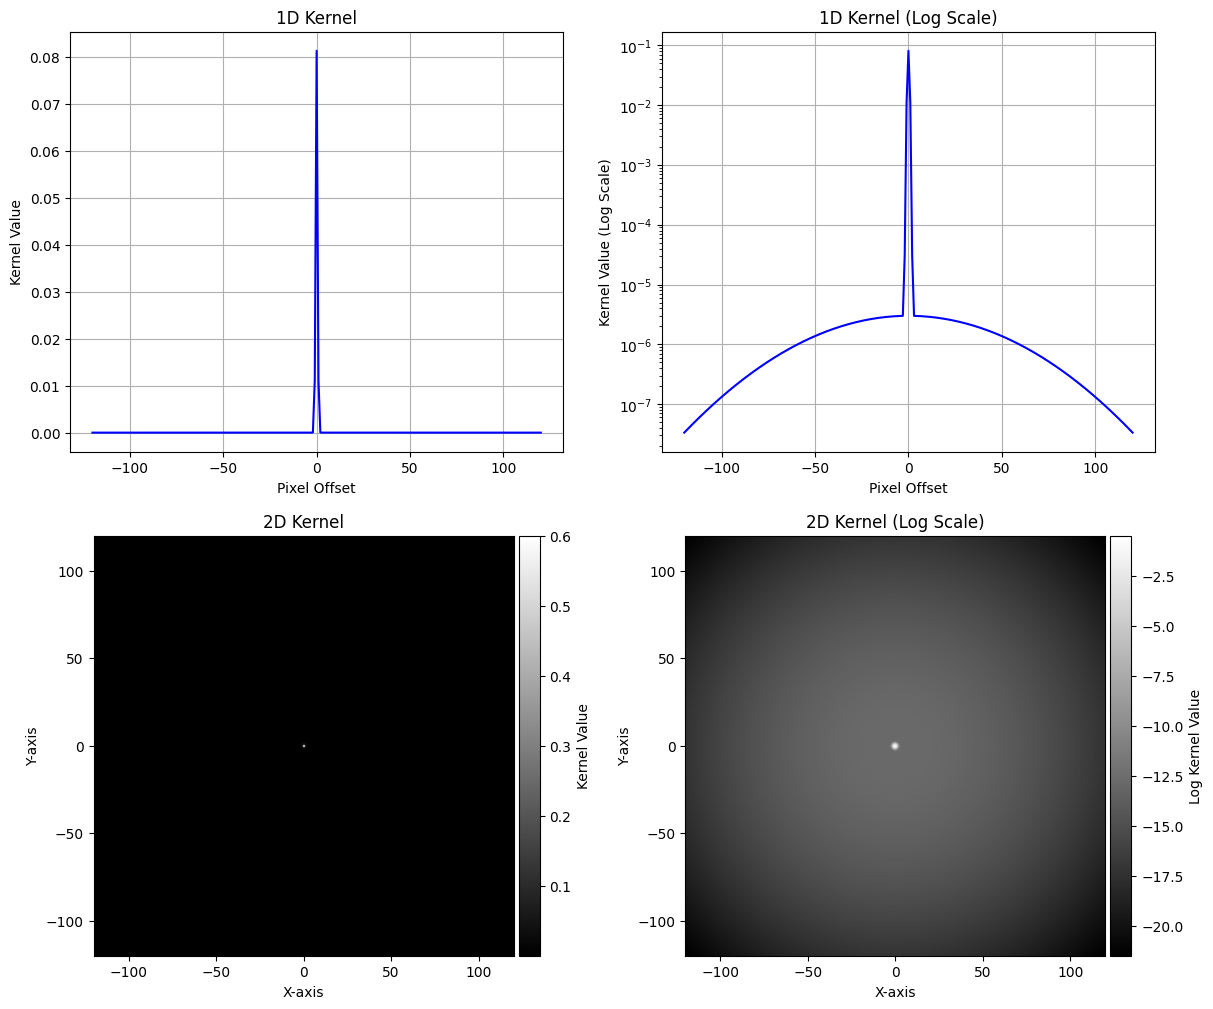

In [201]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# 1D Kernel - Linear
axs[0, 0].plot(x, d1_kernel, label='1D Kernel', color='blue')
axs[0, 0].set_title('1D Kernel')
axs[0, 0].set_xlabel('Pixel Offset')
axs[0, 0].set_ylabel('Kernel Value')
axs[0, 0].grid()

# 1D Kernel - Log
axs[0, 1].plot(x, d1_kernel, color='blue')
axs[0, 1].set_title('1D Kernel (Log Scale)')
axs[0, 1].set_xlabel('Pixel Offset')
axs[0, 1].set_ylabel('Kernel Value (Log Scale)')
axs[0, 1].set_yscale('log')
axs[0, 1].grid()

# 2D Kernel - Linear (with colorbar)
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
im = axs[1, 0].imshow(kernel, cmap='gray', extent=(-r, r, -r, r))
axs[1, 0].set_title('2D Kernel')
axs[1, 0].set_xlabel('X-axis')
axs[1, 0].set_ylabel('Y-axis')
axs[1, 0].axis('equal')
axs[1, 0].grid(False)
fig.colorbar(im, cax=cax, label='Kernel Value')

# 2D Kernel - Log (with colorbar)
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
im = axs[1, 1].imshow(np.log(kernel + 1e-10), cmap='gray', extent=(-r, r, -r, r))
axs[1, 1].set_title('2D Kernel (Log Scale)')
axs[1, 1].set_xlabel('X-axis')
axs[1, 1].set_ylabel('Y-axis')
axs[1, 1].axis('equal')
axs[1, 1].grid(False)
fig.colorbar(im, cax=cax, label='Log Kernel Value')




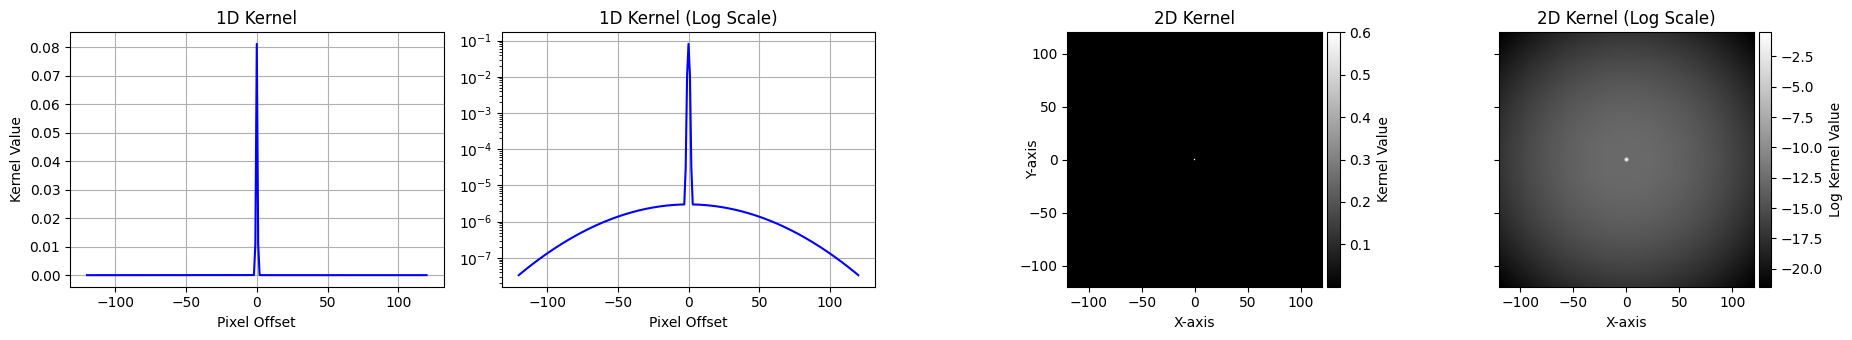

In [202]:
# Same plot but all figures in one row
fig, axs = plt.subplots(1, 4, figsize=(18, 3.5))
plt.subplots_adjust(wspace=-0.0)
# 1D Kernel - Linear
axs[0].plot(x, d1_kernel, label='1D Kernel', color='blue')
axs[0].set_title('1D Kernel')
axs[0].set_xlabel('Pixel Offset')
axs[0].set_ylabel('Kernel Value')
axs[0].grid()
# 1D Kernel - Log
axs[1].plot(x, d1_kernel, color='blue')
axs[1].set_title('1D Kernel (Log Scale)')
axs[1].set_xlabel('Pixel Offset')
axs[1].set_yscale('log')
axs[1].grid()
# 2D Kernel - Linear (with colorbar)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
im = axs[2].imshow(kernel, cmap='gray', extent=(-r, r, -r, r))
axs[2].set_title('2D Kernel')
axs[2].set_xlabel('X-axis')
axs[2].set_ylabel('Y-axis')
axs[2].yaxis.labelpad = -15  # or try -2 for even closer

axs[2].axis('equal')
axs[2].grid(False)
fig.colorbar(im, cax=cax, label='Kernel Value')
# 2D Kernel - Log (with colorbar)
divider = make_axes_locatable(axs[3])
cax = divider.append_axes("right", size="5%", pad=0.05)
im = axs[3].imshow(np.log(kernel + 1e-10), cmap='gray', extent=(-r, r, -r, r))
axs[3].set_title('2D Kernel (Log Scale)')
axs[3].set_xlabel('X-axis')
# axs[3].set_ylabel('Y-axis')
# axs[3].yaxis.labelpad = -15
# axs[3].axis('equal')
axs[3].grid(False)
axs[3].tick_params(labelleft=False)
axs[3].set_ylabel("")
fig.colorbar(im, cax=cax, label='Log Kernel Value')
plt.tight_layout()

# Shrink the main axes (for 2D kernels) slightly to reduce whitespace
axs[2].set_position([axs[2].get_position().x0,
                     axs[2].get_position().y0,
                     0.30,  # width: reduce from default ~0.21
                     axs[2].get_position().height])

axs[3].set_position([axs[3].get_position().x0,
                     axs[3].get_position().y0,
                     0.30,
                     axs[3].get_position().height])
plt.show()


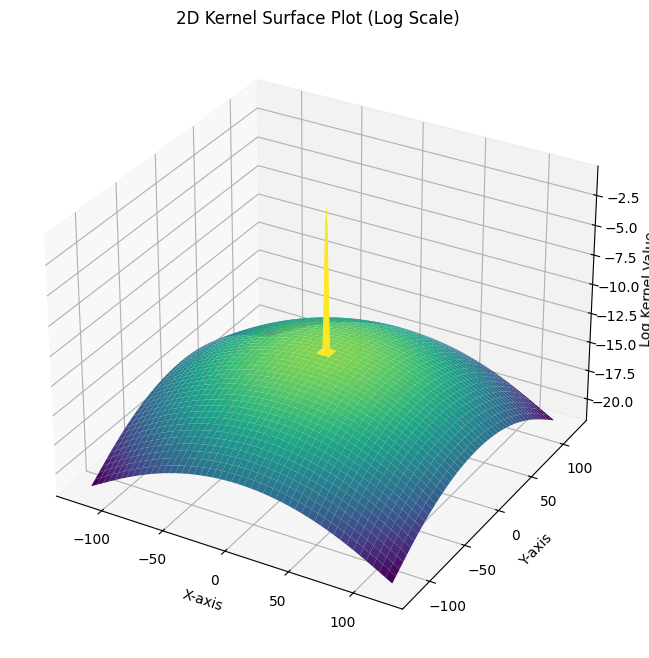

In [203]:
# Show the 2d kernel as a 3D surface plot on log scale
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x, x)
ax.plot_surface(X, Y, np.log(kernel + 1e-10), cmap='viridis', edgecolor='none')
ax.set_title('2D Kernel Surface Plot (Log Scale)')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Log Kernel Value')
plt.show()



## Load and process a sample image and compare the results


In [225]:
# idx = 22 # Handbag
# idx = 0 # House
idx = 16 # Slide
# idx = 198 # Lamp?
# idx = 4 # Coop
# idx = 19 # Bar

# Load file
strength = 60

paths = get_image_paths()

raw = rawpy.imread(paths["long_exp"][idx])
diffused_postprocessed = rawpy.imread(paths["filter_long_exp"][idx]).postprocess(use_camera_wb=True, half_size=False)

rawpy_postprocessed = raw.postprocess(use_camera_wb=True, half_size=False)
raw_image = raw.raw_image_visible

wb_constants = np.array(raw.camera_whitebalance) / raw.camera_whitebalance[1] 
bloomed_image = bloom_image(load_image(paths["long_exp"][idx]), extend_factor=strength, downscale_factor=1, method1=True, wb_constants=wb_constants)

# Rescale the bloomed image to the original raw image's range
h,w = raw_image.shape
black_point = np.array(raw.black_level_per_channel)
white_point = np.array(raw.camera_white_level_per_channel)
rescaled_bloomed_image = (bloomed_image * (white_point - black_point) + black_point).astype(np.uint16)
raw.raw_image_visible[:h, :w] = unpack_raw(rescaled_bloomed_image)
bloomed_postprocessed = raw.postprocess(use_camera_wb=True, half_size=False)



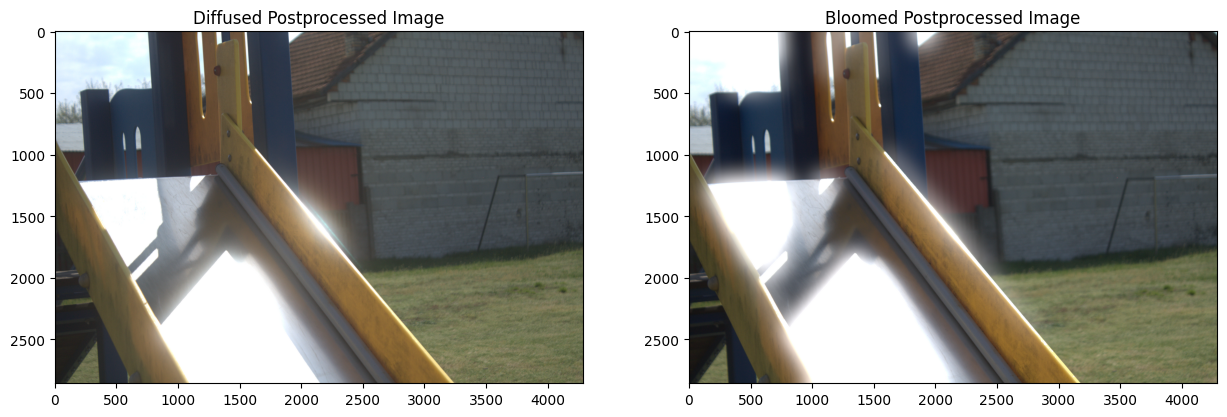

In [226]:
# Show the original and bloomed postprocessed images side by side
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(diffused_postprocessed)
plt.title('Diffused Postprocessed Image')
plt.subplot(1, 2, 2)
plt.imshow(bloomed_postprocessed)
plt.title('Bloomed Postprocessed Image')
plt.show()